In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

from PIL import Image
from scipy.stats import binned_statistic

sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [116]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

In [117]:
udg_cat = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel_after_viz_w_missed.fits')

fake_udg_cat = Table.read('./Catalog/random_field/fake_udg_cat_220711.fits')
density_bkg = len(fake_udg_cat) / (5 * 20) / 24 # bkg per sqr deg

In [118]:
from scipy.stats import binned_statistic

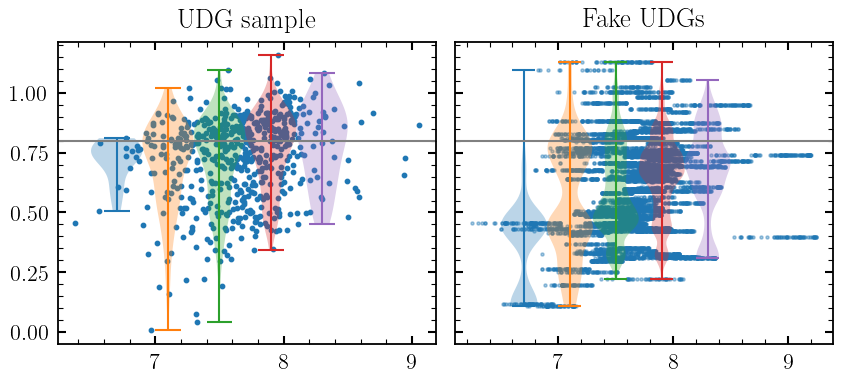

In [119]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

plt.sca(ax1)
res = binned_statistic(udg_cat['log_m_star'].data, udg_cat['log_m_star'].data, range=(6.5, 8.5), bins=5)
cen = 0.5 * (res.bin_edges[1:] + res.bin_edges[:-1])
for i in range(5):
    plt.violinplot(udg_cat[res.binnumber == i+1]['g-i'].data, 
                   widths=np.diff(cen)[0],
                   positions=[cen[i]])
    
plt.scatter(udg_cat['log_m_star'], udg_cat['g-i'], zorder=0, s=10)
plt.axhline(0.8, color='gray')
plt.title('UDG sample')

plt.sca(ax2)
res = binned_statistic(fake_udg_cat['log_m_star'].data, fake_udg_cat['log_m_star'].data, range=(6.5, 8.5), bins=5)
cen = 0.5 * (res.bin_edges[1:] + res.bin_edges[:-1])
for i in range(5):
    plt.violinplot(fake_udg_cat[res.binnumber == i+1]['g-i'].data, 
                   widths=np.diff(cen)[0],
                   positions=[cen[i]])

plt.scatter(fake_udg_cat['log_m_star'], fake_udg_cat['g-i'], zorder=0, s=5, alpha=0.4)
plt.axhline(0.8, color='gray')
plt.title('Fake UDGs')


plt.subplots_adjust(wspace=0.05)

---
### Add weights

In [120]:
p2 = 0.32
n_bins = 20

In [138]:
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

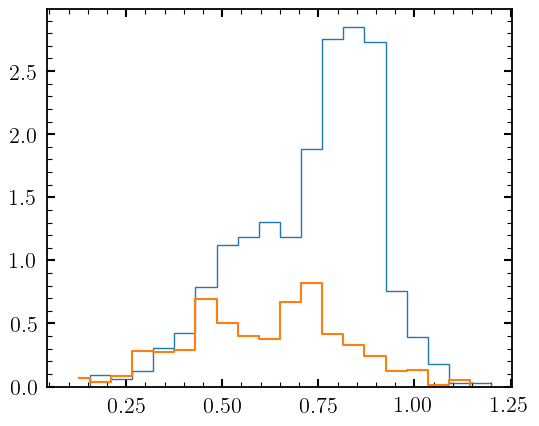

In [139]:
n1, bins, _ = plt.hist(udg_cat['g-i'], bins=n_bins, range=(0.1, 1.2), histtype='step', density=True)
n2, bins = np.histogram(fake_udg_cat['g-i'], 
                        bins=n_bins, range=(0.1, 1.2), density=True);

plt.step(0.5 * (bins[:-1] + bins[1:]), p2 * n2, where='mid', label='mid')

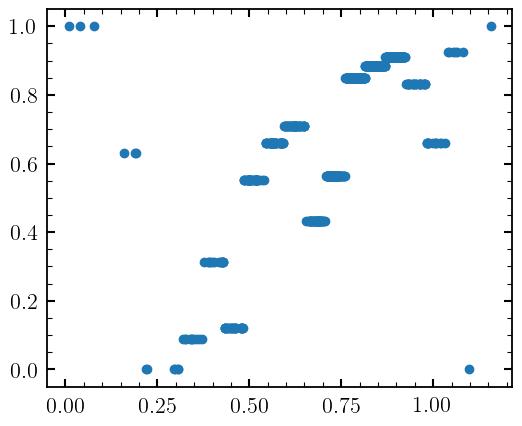

In [140]:
n_weights = p2 * n2 / n1
n_weights = np.nan_to_num(n_weights, nan=0.0, posinf=0.0, neginf=0.0)
n_weights[n_weights >= 1] = 1

weights1 = 1 - n_weights[np.digitize(udg_cat['g-i'], bins) - 1]
plt.scatter(udg_cat['g-i'], weights1)

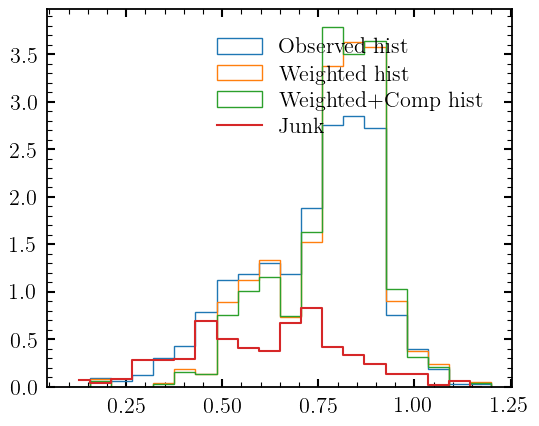

In [141]:
plt.hist(udg_cat['g-i'], bins=n_bins, range=(0.1, 1.2), 
         density=True, histtype='step', label='Observed hist')
plt.hist(udg_cat['g-i'], bins=n_bins, range=(0.1, 1.2), 
         weights=weights1, density=True, histtype='step', label='Weighted hist')


weights2 = weights1 / udg_cat['completeness']
weights2 = np.nan_to_num(weights2, posinf=0.0, neginf=0.0)
weights2 /= np.percentile(weights2, 80)

plt.hist(udg_cat['g-i'], bins=n_bins, range=(0.1, 1.2), 
         weights=weights2, density=True, histtype='step', label='Weighted+Comp hist')

plt.step(0.5 * (bins[:-1] + bins[1:]), p2 * n2, where='mid', label='Junk')

plt.legend()

In [142]:
import weighted
from matplotlib.cbook import violin_stats
import statsmodels.api as sm

In [143]:
# https://gist.github.com/jquacinella/1a6341f0f1446973714c
def vdensity_with_weights(weights):
    ''' Outer function allows innder function access to weights. Matplotlib
    needs function to take in data and coords, so this seems like only way
    to 'pass' custom density function a set of weights '''
    
    def vdensity(data, coords):
        ''' Custom matplotlib weighted violin stats function '''
        # Using weights from closure, get KDE fomr statsmodels
        weighted_cost = sm.nonparametric.KDEUnivariate(data)
        weighted_cost.fit(fft=False, weights=weights)

        # Return y-values for graph of KDE by evaluating on coords
        return weighted_cost.evaluate(coords)
    return vdensity

def custom_violin_stats(data, weights):
    # Get weighted median and mean (using weighted module for median)
    median = weighted.quantile_1D(data, weights, 0.5)
    mean, sumw = np.ma.average(data, weights=list(weights), returned=True)
    
    # Use matplotlib violin_stats, which expects a function that takes in data and coords
    # which we get from closure above
    results = violin_stats(data, vdensity_with_weights(weights))
    
    # Update result dictionary with our updated info
    results[0][u"mean"] = mean
    results[0][u"median"] = median
    
    # No need to do this, since it should be populated from violin_stats
    # results[0][u"min"] =  np.min(data)
    # results[0][u"max"] =  np.max(data)

    return results

In [144]:
V = udg_cat['mag'][:, 0] - 0.5784 * (udg_cat['mag'][:, 0] - udg_cat['mag'][:, 1]) - 0.0038
V_abs = V - 25 - 5 * np.log10(udg_cat['host_ang_diam_dist'].data *
                 (1 + udg_cat['host_z'].data)**2)
quenched = (udg_cat['g-i'] > (-0.067 * V_abs - 0.28))

avg comp: 0.3942164527337957
avg comp: 0.6016467503319585
avg comp: 0.7028934153638889
avg comp: 0.8490621273846622
avg comp: 0.8744929114048667
avg comp: 0.8764699432873541


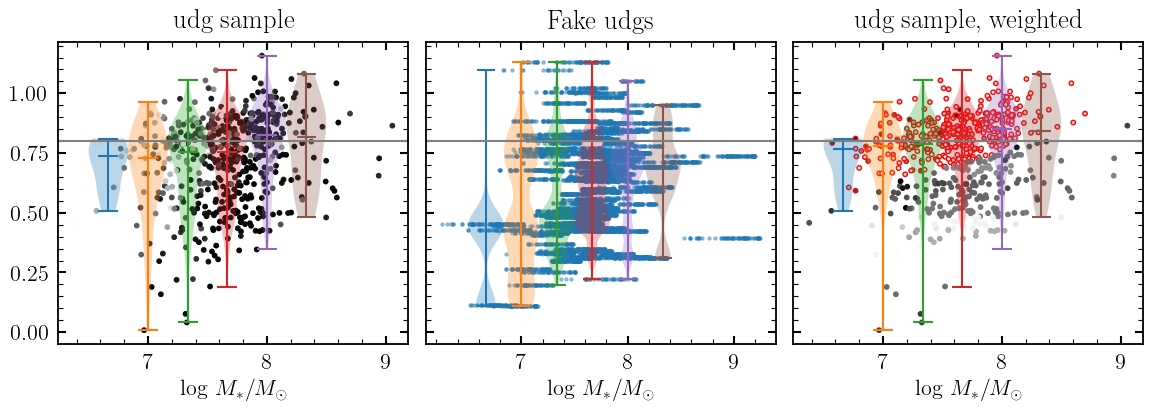

In [145]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

plt.sca(ax1)
res = binned_statistic(udg_cat['log_m_star'].data, udg_cat['log_m_star'].data, range=(6.5, 8.5), bins=6)
cen = 0.5 * (res.bin_edges[1:] + res.bin_edges[:-1])
for i in range(6):
    plt.violinplot(udg_cat[res.binnumber == i+1]['g-i'].data, 
                   widths=np.diff(cen)[0], showmedians=True,
                   positions=[cen[i]])
    
plt.scatter(udg_cat['log_m_star'], udg_cat['g-i'], c=udg_cat['completeness'], cmap='Greys', zorder=0, s=10)
plt.axhline(0.8, color='gray')
plt.xlabel(r'$\log\, M_*/M_\odot$')
plt.title('udg sample')

plt.sca(ax2)
res = binned_statistic(fake_udg_cat['log_m_star'].data, fake_udg_cat['log_m_star'].data, range=(6.5, 8.5), bins=6)
cen = 0.5 * (res.bin_edges[1:] + res.bin_edges[:-1])
for i in range(6):
    plt.violinplot(fake_udg_cat[res.binnumber == i+1]['g-i'].data, 
                   widths=np.diff(cen)[0],
                   positions=[cen[i]])

plt.scatter(fake_udg_cat['log_m_star'], fake_udg_cat['g-i'], zorder=0, s=5, alpha=0.4)
plt.axhline(0.8, color='gray')
plt.xlabel(r'$\log\, M_*/M_\odot$')
plt.title('Fake udgs')


plt.sca(ax3)
res = binned_statistic(udg_cat['log_m_star'].data, udg_cat['log_m_star'].data, range=(6.5, 8.5), bins=6)
cen = 0.5 * (res.bin_edges[1:] + res.bin_edges[:-1])
for i in range(6):
    print('avg comp:', np.mean(udg_cat[res.binnumber == i+1]['completeness'].data))
    vpstats1 = custom_violin_stats(udg_cat[res.binnumber == i+1]['g-i'].data, 
                                   weights2[res.binnumber == i+1])
    ax3.violin(vpstats1, widths=np.diff(cen)[0],
               positions=[cen[i]], vert=True, showextrema=True,
               showmedians=True)
    
plt.scatter(udg_cat['log_m_star'][quenched], udg_cat['g-i'][quenched], 
            c=np.log10(weights2)[quenched], 
#             vmax=1, 
            zorder=0, s=10, edgecolor='r', cmap='Greys')

plt.scatter(udg_cat['log_m_star'][~quenched], udg_cat['g-i'][~quenched], 
            c=np.log10(weights2)[~quenched], 
#             vmax=1, 
            zorder=0, s=10, cmap='Greys')

plt.axhline(0.8, color='gray')
plt.xlabel(r'$\log\, M_*/M_\odot$')
plt.title('udg sample, weighted')


plt.subplots_adjust(wspace=0.05)

(2.4, 4.0)

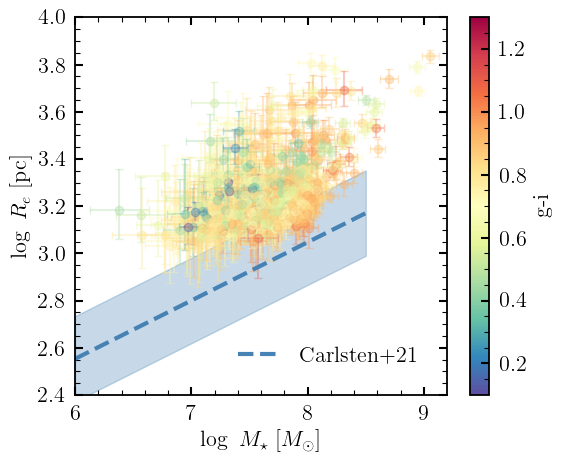

In [146]:
import matplotlib
from matplotlib.colors import Normalize

norm = Normalize(vmin=0.1, vmax=1.3)
cmap = matplotlib.cm.Spectral_r
sm = matplotlib.cm.ScalarMappable(norm, cmap)
sm.set_array([])
_colors = sm.to_rgba(udg_cat['g-i'])

yerrs = np.array([np.log10(udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err']) - np.log10(udg_cat['rhalf_phys']), 
         np.log10(udg_cat['rhalf_phys']) - np.log10(udg_cat['rhalf_phys'] - udg_cat['rhalf_phys_err'])])
for i,_ in enumerate(udg_cat['log_m_star']):
    sct = plt.errorbar(
        udg_cat['log_m_star'][i], 
        np.log10(udg_cat['rhalf_phys'][i]) + 3, # in pc
        xerr=udg_cat['log_m_star_err'][i], 
        yerr=yerrs[:, i].reshape(-1, 1),
        color=_colors[i],
        fmt='o', alpha=0.35)
plt.colorbar(sm, label='g-i')


# Carlsten mass-size relation
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m
x = np.linspace(6, 8.5)
plt.fill_between(x, mass_size_carlsten(x) - 0.181, 
                 mass_size_carlsten(x) + 0.181, 
                 color='steelblue', alpha=0.3)
plt.plot(x, mass_size_carlsten(x), ls='--', 
         color='steelblue', lw=3, label='Carlsten+21')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ R_{e}\ [\rm pc]$')
plt.legend(loc='lower right')

plt.xlim(6., 9.2)
plt.ylim(2.4, 4.0)

### Average (weighted) color

Text(0.5, 1.0, 'UDG sample')

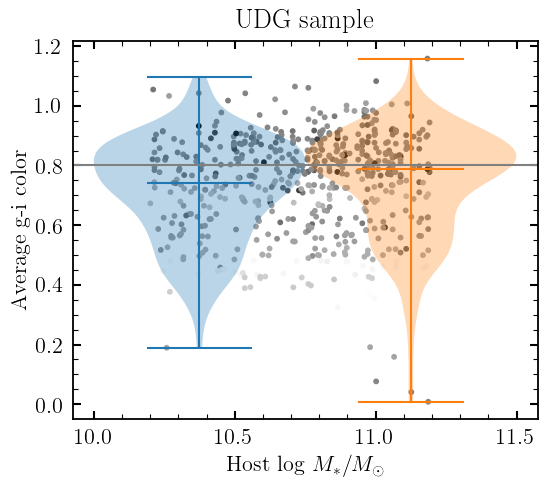

In [147]:
res = binned_statistic(udg_cat['host_stellar_mass'].data, udg_cat['host_stellar_mass'].data, range=(10, 11.5), bins=2)
cen = 0.5 * (res.bin_edges[1:] + res.bin_edges[:-1])
for i in range(len(cen)):
    plt.violinplot(udg_cat[res.binnumber == i+1]['g-i'].data, 
                   widths=np.diff(cen)[0], showmedians=True,
                   positions=[cen[i]])
    
plt.scatter(udg_cat['host_stellar_mass'], udg_cat['g-i'], c=np.log10(weights2), 
            cmap='Greys', zorder=0, s=10)
plt.axhline(0.8, color='gray')
plt.xlabel(r'Host $\log\, M_*/M_\odot$')
plt.ylabel(r'Average g-i color')
plt.title('UDG sample')

Text(0.5, 1.0, 'UDG sample')

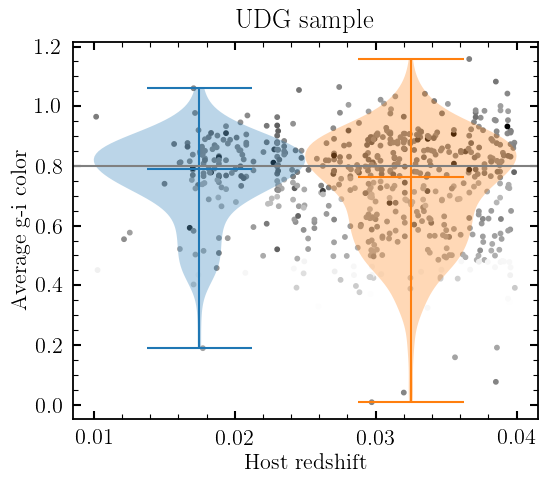

In [148]:
res = binned_statistic(udg_cat['host_z'].data, udg_cat['host_z'].data, range=(0.01, 0.04), bins=2)
cen = 0.5 * (res.bin_edges[1:] + res.bin_edges[:-1])
for i in range(len(cen)):
    plt.violinplot(udg_cat[res.binnumber == i+1]['g-i'].data, 
                   widths=np.diff(cen)[0], showmedians=True,
                   positions=[cen[i]])
    
plt.scatter(udg_cat['host_z'], udg_cat['g-i'], c=np.log10(weights2), 
            cmap='Greys', zorder=0, s=10)
plt.axhline(0.8, color='gray')
plt.xlabel(r'Host redshift')
plt.ylabel(r'Average g-i color')
plt.title('UDG sample')

In [149]:
#### Quenched frac data
saga_q = np.array([[6.747422680412371, 0.3474698795180722],
          [7.247422680412371, 0.35903614457831323],
          [7.747422680412371, 0.188433734939759],
          [8.24742268041237, 0.19132530120481916],
          [8.74742268041237, 0.11759036144578305],
          [9.24742268041237, 0.010602409638553967]])
saga_q_err = np.array([[-0.1, 0.12], [-0.084, 0.094], [-0.06, 0.078], 
              [-0.05, 0.07], [-0.05, 0.091], [-0.1, 0.1]])

In [150]:
elves_confirmed_q = np.array([5.742268041237113, 0.8506024096385543,
6.252577319587629, 0.8650602409638555,
6.742268041237113, 0.752289156626506,
7.247422680412371, 0.6612048192771085,
7.747422680412371, 0.7334939759036145,
8.24742268041237, 0.392289156626506,
8.74742268041237, 0.36337349397590357,
9.24742268041237, 0.12626506024096373]).reshape(-1, 2)

elves_confirmed_q_upper = np.array([5.752577319587629, 0.895421686746988,
6.242268041237113, 0.9026506024096386,
6.757731958762887, 0.7956626506024097,
7.247422680412371, 0.7204819277108434,
7.747422680412371, 0.7913253012048194,
8.24742268041237, 0.4949397590361446,
8.74742268041237, 0.5137349397590361,
9.24742268041237, 0.28385542168674693]).reshape(-1, 2)

elves_confirmed_q_lower = np.array([5.752577319587629, 0.7927710843373494,
6.252577319587629, 0.8144578313253013,
6.742268041237113, 0.6959036144578314,
7.247422680412371, 0.5961445783132531,
7.747422680412371, 0.6684337349397591,
8.24742268041237, 0.29831325301204814,
8.74742268041237, 0.23759036144578305,
9.231958762886597, 0.05831325301204815]).reshape(-1, 2)

In [151]:
V = udg_cat['mag'][:, 0] - 0.5784 * (udg_cat['mag'][:, 0] - udg_cat['mag'][:, 1]) - 0.0038
V_abs = V - 25 - 5 * np.log10(udg_cat['host_ang_diam_dist'].data *
                 (1 + udg_cat['host_z'].data)**2)
quenched = (udg_cat['g-i'] > (-0.067 * V_abs - 0.28))
# red = (udg_cat['g-i'] > 0.8)
red = quenched
flag = np.ones_like(udg_cat['host_z']).data.astype(bool)

(0.0, 1.0)

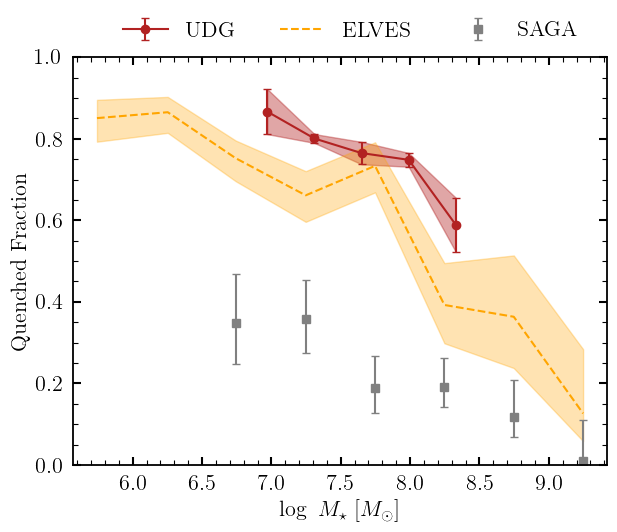

In [152]:
fig, ax = plt.subplots(figsize=(6.9, 5.4))

y1, cens = moving_binned_statistic(udg_cat['log_m_star'][flag],
                        red[flag].astype(float) * weights2[flag],  
                        x_err=udg_cat['log_m_star_err'][flag],
                        statistic='sum', range_=(6.8, 8.5), bins=5, n_slide=20)

y2, cens = moving_binned_statistic(udg_cat['log_m_star'][flag],
                        weights2[flag],  
                        x_err=udg_cat['log_m_star_err'][flag],
                        statistic='sum', range_=(6.8, 8.5), bins=5, n_slide=20)

num, cens = moving_binned_statistic(udg_cat['log_m_star'][flag],
                        udg_cat['log_m_star'][flag],  
                        x_err=udg_cat['log_m_star_err'][flag],
                        statistic='count', range_=(6.8, 8.5), bins=5, n_slide=20)
num = np.median(num, axis=0)

quench_frac = np.median(y1 / y2, axis=0)
quench_frac_std = np.sqrt(quench_frac * (1 - quench_frac) / num) 
quench_frac_std = np.std(y1 / y2, axis=0)

plt.errorbar(cens, 
             quench_frac, 
             yerr=quench_frac_std, fmt='o-', 
             label='UDG',
             color='firebrick', zorder=10)

plt.fill_between(cens, 
                 quench_frac - quench_frac_std, 
                 quench_frac + quench_frac_std, 
                 color='firebrick', alpha=0.4)


plt.plot(elves_confirmed_q[:, 0], elves_confirmed_q[:, 1], 
         color='orange', label='ELVES', ls='--', zorder=0)
plt.fill_between(elves_confirmed_q[:, 0], 
                 elves_confirmed_q_upper[:, 1], 
                 elves_confirmed_q_lower[:, 1], 
                 color='orange', 
                 alpha=0.3)

plt.errorbar(saga_q[:, 0], saga_q[:, 1], 
             yerr=[-saga_q_err[:, 0], saga_q_err[:, 1]], fmt='s', 
             color='grey',
             label='SAGA')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction') #  ($g - i > 0.8$)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0,2]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
            ncol=3, bbox_to_anchor=(0.5, 0.66, 0.5, 0.5))

plt.ylim(0, 1)

(0.0, 1.16)

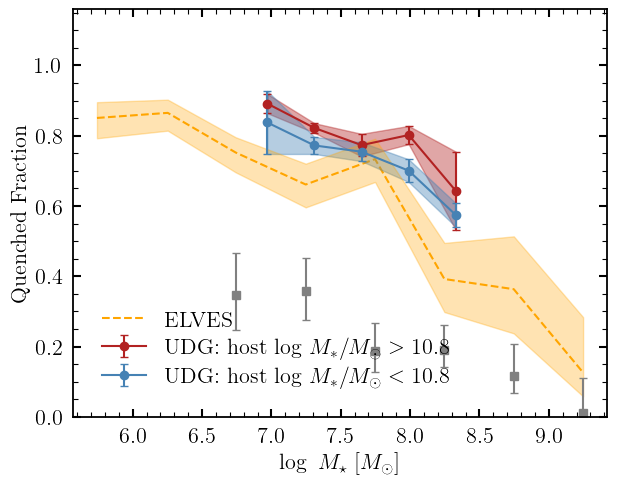

In [153]:
fig, ax = plt.subplots(figsize=(6.9, 5.4))

thresh = 10.8
for i, flag in enumerate([(udg_cat['host_stellar_mass'] > thresh), 
                          (udg_cat['host_stellar_mass'] < thresh)]):
    y1, cens = moving_binned_statistic(udg_cat['log_m_star'][flag],
                            red[flag].astype(float) * weights2[flag],  
                            x_err=udg_cat['log_m_star_err'][flag],
                            statistic='sum', range_=(6.8, 8.5), bins=5, n_slide=20)

    y2, cens = moving_binned_statistic(udg_cat['log_m_star'][flag],
                            weights2[flag],  
                            x_err=udg_cat['log_m_star_err'][flag],
                            statistic='sum', range_=(6.8, 8.5), bins=5, n_slide=20)

    num, cens = moving_binned_statistic(udg_cat['log_m_star'][flag],
                            udg_cat['log_m_star'][flag],  
                            x_err=udg_cat['log_m_star_err'][flag],
                            statistic='count', range_=(6.8, 8.5), bins=5, n_slide=20)
    num = np.median(num, axis=0)

    quench_frac = np.median(y1 / y2, axis=0)
    quench_frac_std = np.sqrt(quench_frac * (1 - quench_frac) / num) 
    quench_frac_std = np.std(y1 / y2, axis=0)
    
    sign = '>' if i == 0 else '<'
    color = 'firebrick' if i == 0 else 'steelblue'
    plt.errorbar(cens, 
                 quench_frac, 
                 yerr=quench_frac_std, fmt='o-', 
                 label=f'UDG: host $\log\, M_*/M_\odot {sign} {thresh}$',
                 color=color, zorder=10)

    plt.fill_between(cens, 
                     quench_frac - quench_frac_std, 
                     quench_frac + quench_frac_std, 
                     color=color, alpha=0.4)


plt.plot(elves_confirmed_q[:, 0], elves_confirmed_q[:, 1], 
         color='orange', label='ELVES', ls='--', zorder=0)
plt.fill_between(elves_confirmed_q[:, 0], 
                 elves_confirmed_q_upper[:, 1], 
                 elves_confirmed_q_lower[:, 1], 
                 color='orange', 
                 alpha=0.3)

plt.errorbar(saga_q[:, 0], saga_q[:, 1], 
             yerr=[-saga_q_err[:, 0], saga_q_err[:, 1]], fmt='s', 
             color='grey',
             label='SAGA')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction') #  ($g - i > 0.8$)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 1, 2]#[1,0,2]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
#            loc='lower left'
#            bbox_to_anchor=(0.5, 0.66, 0.5, 0.5)
          )
plt.ylim(0, 1.16)

#### Morphology

(0.0, 1.16)

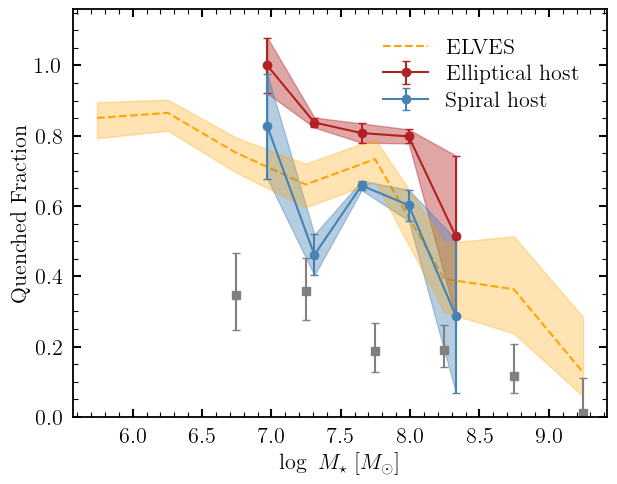

In [101]:
fig, ax = plt.subplots(figsize=(6.9, 5.4))

for i, flag in enumerate([(udg_cat['host_elliptical'] == 1), 
                          (udg_cat['host_spiral'] == 1)]):
    y1, cens = moving_binned_statistic(udg_cat['log_m_star'][flag],
                            red[flag].astype(float) * weights2[flag],  
                            x_err=udg_cat['log_m_star_err'][flag],
                            statistic='sum', range_=(6.8, 8.5), bins=5, n_slide=20)

    y2, cens = moving_binned_statistic(udg_cat['log_m_star'][flag],
                            weights2[flag],  
                            x_err=udg_cat['log_m_star_err'][flag],
                            statistic='sum', range_=(6.8, 8.5), bins=5, n_slide=20)

    num, cens = moving_binned_statistic(udg_cat['log_m_star'][flag],
                            udg_cat['log_m_star'][flag],  
                            x_err=udg_cat['log_m_star_err'][flag],
                            statistic='count', range_=(6.8, 8.5), bins=5, n_slide=20)
    num = np.median(num, axis=0)

    quench_frac = np.median(y1 / y2, axis=0)
    quench_frac_std = np.sqrt(quench_frac * (1 - quench_frac) / num) 
    quench_frac_std = np.std(y1 / y2, axis=0)
    
    label = 'Elliptical host' if i == 0 else 'Spiral host'
    color = 'firebrick' if i == 0 else 'steelblue'
    plt.errorbar(cens, 
                 quench_frac, 
                 yerr=quench_frac_std, fmt='o-', 
                 label=label,
                 color=color, zorder=10)

    plt.fill_between(cens, 
                     quench_frac - quench_frac_std, 
                     quench_frac + quench_frac_std, 
                     color=color, alpha=0.4)


plt.plot(elves_confirmed_q[:, 0], elves_confirmed_q[:, 1], 
         color='orange', label='ELVES', ls='--', zorder=0)
plt.fill_between(elves_confirmed_q[:, 0], 
                 elves_confirmed_q_upper[:, 1], 
                 elves_confirmed_q_lower[:, 1], 
                 color='orange', 
                 alpha=0.3)

plt.errorbar(saga_q[:, 0], saga_q[:, 1], 
             yerr=[-saga_q_err[:, 0], saga_q_err[:, 1]], fmt='s', 
             color='grey',
             label='SAGA')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction') #  ($g - i > 0.8$)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 1, 2]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
#            loc='lower left'
#            bbox_to_anchor=(0.5, 0.66, 0.5, 0.5)
          )
plt.ylim(0, 1.16)

In [53]:
import pickle

In [54]:
with open('./Catalog/NSA/nsa_lsbg_match.pkl', 'rb') as f:
    nsa_cat = pickle.load(f)

In [55]:
host_gi = []
for name in udg_cat['host_name'].data:
    host = nsa_cat[nsa_cat['IAUNAME'].data.data == name][0]
    try:
        host_gi.append(-2.5 * np.log10(host['ELPETRO_FLUX'][3] / host['ELPETRO_FLUX'][5]))
    except:
        host_gi.append(np.nan)

In [56]:
host_gi = np.array(host_gi)

(0.0, 1.16)

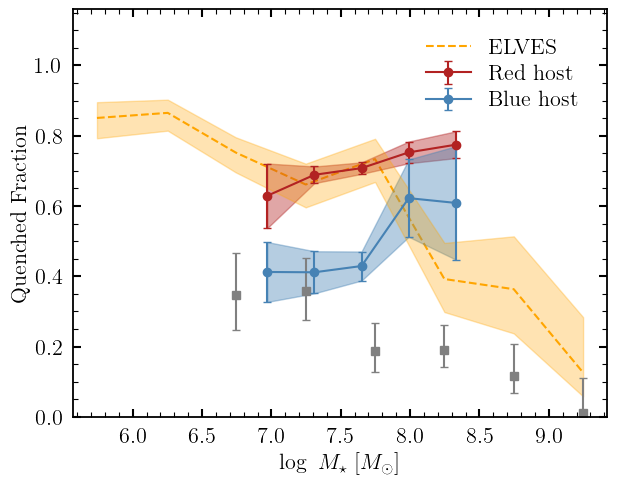

In [57]:
fig, ax = plt.subplots(figsize=(6.9, 5.4))

for i, flag in enumerate([(host_gi > 1.2), 
                          (host_gi < 1.2)]):
    y1, cens = moving_binned_statistic(udg_cat['log_m_star'][flag],
                            red[flag].astype(float) * weights2[flag],  
                            x_err=udg_cat['log_m_star_err'][flag],
                            statistic='sum', range_=(6.8, 8.5), bins=5, n_slide=20)

    y2, cens = moving_binned_statistic(udg_cat['log_m_star'][flag],
                            weights2[flag],  
                            x_err=udg_cat['log_m_star_err'][flag],
                            statistic='sum', range_=(6.8, 8.5), bins=5, n_slide=20)

    num, cens = moving_binned_statistic(udg_cat['log_m_star'][flag],
                            udg_cat['log_m_star'][flag],  
                            x_err=udg_cat['log_m_star_err'][flag],
                            statistic='count', range_=(6.8, 8.5), bins=5, n_slide=20)
    num = np.median(num, axis=0)

    quench_frac = np.median(y1 / y2, axis=0)
    quench_frac_std = np.sqrt(quench_frac * (1 - quench_frac) / num) 
    quench_frac_std = np.std(y1 / y2, axis=0)
    
    label = 'Red host' if i == 0 else 'Blue host'
    color = 'firebrick' if i == 0 else 'steelblue'
    plt.errorbar(cens, 
                 quench_frac, 
                 yerr=quench_frac_std, fmt='o-', 
                 label=label,
                 color=color, zorder=10)

    plt.fill_between(cens, 
                     quench_frac - quench_frac_std, 
                     quench_frac + quench_frac_std, 
                     color=color, alpha=0.4)


plt.plot(elves_confirmed_q[:, 0], elves_confirmed_q[:, 1], 
         color='orange', label='ELVES', ls='--', zorder=0)
plt.fill_between(elves_confirmed_q[:, 0], 
                 elves_confirmed_q_upper[:, 1], 
                 elves_confirmed_q_lower[:, 1], 
                 color='orange', 
                 alpha=0.3)

plt.errorbar(saga_q[:, 0], saga_q[:, 1], 
             yerr=[-saga_q_err[:, 0], saga_q_err[:, 1]], fmt='s', 
             color='grey',
             label='SAGA')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction') #  ($g - i > 0.8$)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 1, 2]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
#            loc='lower left'
#            bbox_to_anchor=(0.5, 0.66, 0.5, 0.5)
          )
plt.ylim(0, 1.16)

In [51]:
thresh = 1.2
plt.hist(udg_cat['host_stellar_mass'][(host_gi < thresh)], histtype='step', label='blue host')
plt.hist(udg_cat['host_stellar_mass'][(host_gi > thresh)], histtype='step', label='red host')

plt.legend()

NameError: name 'host_gi' is not defined

In [52]:
thresh = 1.2
plt.hist(udg_cat['host_z'][(host_gi < thresh)], histtype='step', label='blue host')
plt.hist(udg_cat['host_z'][(host_gi > thresh)], histtype='step', label='red host')

plt.legend()

NameError: name 'host_gi' is not defined

avg comp: 0.21689820861124554
'ScalarMappable' object has no attribute 'nonparametric'
avg comp: 0.2841361625629058
'ScalarMappable' object has no attribute 'nonparametric'
avg comp: 0.3300538568382696
'ScalarMappable' object has no attribute 'nonparametric'
avg comp: 0.391761485882565
'ScalarMappable' object has no attribute 'nonparametric'
avg comp: 0.43068711864583287
'ScalarMappable' object has no attribute 'nonparametric'
avg comp: 0.6528314854038124
'ScalarMappable' object has no attribute 'nonparametric'


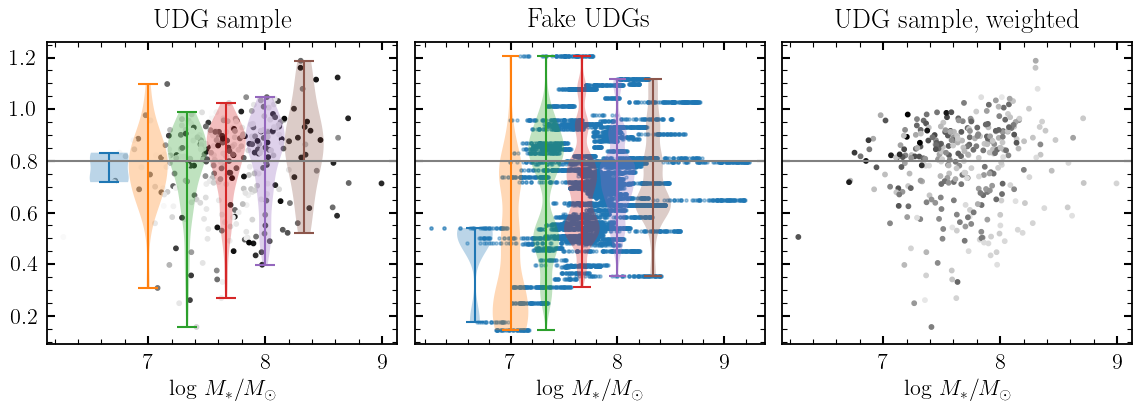

In [53]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

flag = (host_gi > 1.1)
plt.sca(ax1)
res = binned_statistic(udg_cat[flag]['log_m_star'].data, udg_cat[flag]['log_m_star'].data, range=(6.5, 8.5), bins=6)
cen = 0.5 * (res.bin_edges[1:] + res.bin_edges[:-1])
for i in range(6):
    try:
        plt.violinplot(udg_cat[flag][res.binnumber == i+1]['g-i'].data, 
                       widths=np.diff(cen)[0],
                       positions=[cen[i]])
    except:
        pass
plt.scatter(udg_cat[flag]['log_m_star'], udg_cat[flag]['g-i'], 
            c=udg_cat[flag]['completeness'], cmap='Greys', zorder=0, s=10)
plt.axhline(0.8, color='gray')
plt.xlabel(r'$\log\, M_*/M_\odot$')
plt.title('UDG sample')

plt.sca(ax2)
res = binned_statistic(fake_udg_cat['log_m_star'].data, fake_udg_cat['log_m_star'].data, range=(6.5, 8.5), bins=6)
cen = 0.5 * (res.bin_edges[1:] + res.bin_edges[:-1])
for i in range(6):
    try:
        plt.violinplot(fake_udg_cat[res.binnumber == i+1]['g-i'].data, 
                       widths=np.diff(cen)[0],
                       positions=[cen[i]])
    except:
        pass

plt.scatter(fake_udg_cat['log_m_star'], fake_udg_cat['g-i'], zorder=0, s=5, alpha=0.4)
plt.axhline(0.8, color='gray')
plt.xlabel(r'$\log\, M_*/M_\odot$')
plt.title('Fake UDGs')


plt.sca(ax3)
res = binned_statistic(udg_cat[flag]['log_m_star'].data, udg_cat[flag]['log_m_star'].data, range=(6.5, 8.5), bins=6)
cen = 0.5 * (res.bin_edges[1:] + res.bin_edges[:-1])
for i in range(6):
    try:
        print('avg comp:', np.mean(udg_cat[flag][res.binnumber == i+1]['completeness'].data))
        vpstats1 = custom_violin_stats(udg_cat[flag][res.binnumber == i+1]['g-i'].data, 
                                       weights2[flag][res.binnumber == i+1])
        ax3.violin(vpstats1, widths=np.diff(cen)[0],
                   positions=[cen[i]], vert=True, showextrema=True,
                   showmedians=True)
    except Exception as e:
        print(e)
        pass
    
plt.scatter(udg_cat[flag]['log_m_star'], udg_cat[flag]['g-i'], c=np.log10(weights2[flag]), 
#             vmax=1, 
            zorder=0, s=10, cmap='Greys')
plt.axhline(0.8, color='gray')
plt.xlabel(r'$\log\, M_*/M_\odot$')
plt.title('UDG sample, weighted')


plt.subplots_adjust(wspace=0.05)

---
### Radial distance bins ###

In [58]:
udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

(0.0, 1.16)

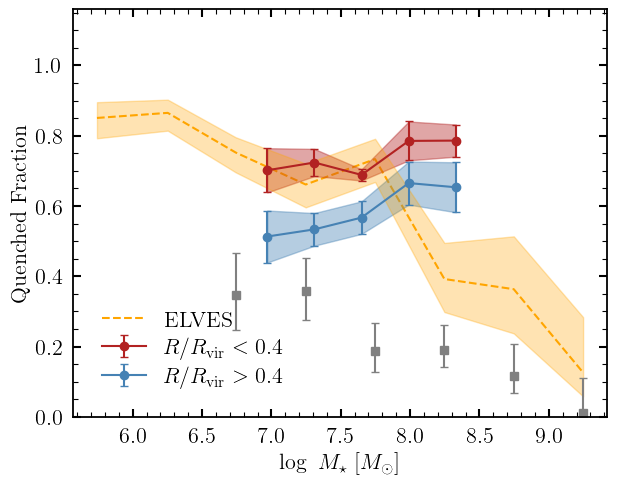

In [59]:
fig, ax = plt.subplots(figsize=(6.9, 5.4))

for i, flag in enumerate([(dist_ratio < 0.4), 
                          (dist_ratio >= 0.4)]):
    y1, cens = moving_binned_statistic(udg_cat['log_m_star'][flag],
                            red[flag].astype(float) * weights2[flag],  
                            x_err=udg_cat['log_m_star_err'][flag],
                            statistic='sum', range_=(6.8, 8.5), bins=5, n_slide=20)

    y2, cens = moving_binned_statistic(udg_cat['log_m_star'][flag],
                            weights2[flag],  
                            x_err=udg_cat['log_m_star_err'][flag],
                            statistic='sum', range_=(6.8, 8.5), bins=5, n_slide=20)

    num, cens = moving_binned_statistic(udg_cat['log_m_star'][flag],
                            udg_cat['log_m_star'][flag],  
                            x_err=udg_cat['log_m_star_err'][flag],
                            statistic='count', range_=(6.8, 8.5), bins=5, n_slide=20)
    num = np.median(num, axis=0)

    quench_frac = np.median(y1 / y2, axis=0)
    quench_frac_std = np.sqrt(quench_frac * (1 - quench_frac) / num) 
    quench_frac_std = np.std(y1 / y2, axis=0)
    
    label = r'$R/R_{\rm vir} < 0.4$' if i == 0 else r'$R/R_{\rm vir} > 0.4$'
    color = 'firebrick' if i == 0 else 'steelblue'
    plt.errorbar(cens, 
                 quench_frac, 
                 yerr=quench_frac_std, fmt='o-', 
                 label=label,
                 color=color, zorder=10)

    plt.fill_between(cens, 
                     quench_frac - quench_frac_std, 
                     quench_frac + quench_frac_std, 
                     color=color, alpha=0.4)


plt.plot(elves_confirmed_q[:, 0], elves_confirmed_q[:, 1], 
         color='orange', label='ELVES', ls='--', zorder=0)
plt.fill_between(elves_confirmed_q[:, 0], 
                 elves_confirmed_q_upper[:, 1], 
                 elves_confirmed_q_lower[:, 1], 
                 color='orange', 
                 alpha=0.3)

plt.errorbar(saga_q[:, 0], saga_q[:, 1], 
             yerr=[-saga_q_err[:, 0], saga_q_err[:, 1]], fmt='s', 
             color='grey',
             label='SAGA')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction') #  ($g - i > 0.8$)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 1, 2]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
#            loc='lower left'
#            bbox_to_anchor=(0.5, 0.66, 0.5, 0.5)
          )
plt.ylim(0, 1.16)

### Redshift

(0.0, 1.16)

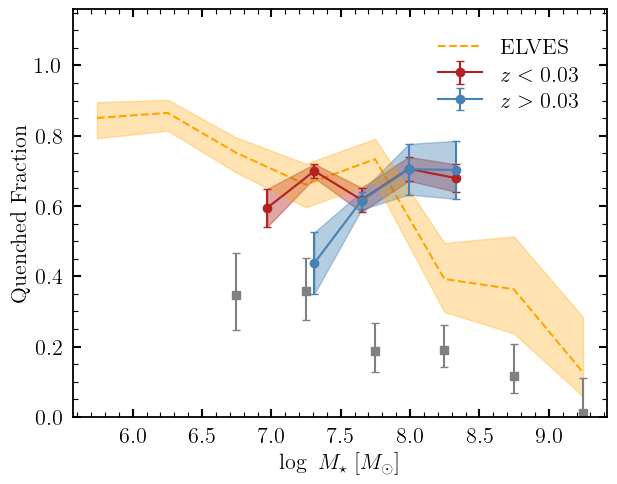

In [60]:
fig, ax = plt.subplots(figsize=(6.9, 5.4))

for i, flag in enumerate([(udg_cat['host_z'] < 0.03), 
                          (udg_cat['host_z'] >= 0.03)]):
    y1, cens = moving_binned_statistic(udg_cat['log_m_star'][flag],
                            red[flag].astype(float) * weights2[flag],  
                            x_err=udg_cat['log_m_star_err'][flag],
                            statistic='sum', range_=(6.8, 8.5), bins=5, n_slide=20)

    y2, cens = moving_binned_statistic(udg_cat['log_m_star'][flag],
                            weights2[flag],  
                            x_err=udg_cat['log_m_star_err'][flag],
                            statistic='sum', range_=(6.8, 8.5), bins=5, n_slide=20)

    num, cens = moving_binned_statistic(udg_cat['log_m_star'][flag],
                            udg_cat['log_m_star'][flag],  
                            x_err=udg_cat['log_m_star_err'][flag],
                            statistic='count', range_=(6.8, 8.5), bins=5, n_slide=20)
    num = np.median(num, axis=0)

    quench_frac = np.median(y1 / y2, axis=0)
    quench_frac_std = np.sqrt(quench_frac * (1 - quench_frac) / num) 
    quench_frac_std = np.std(y1 / y2, axis=0)
    
    label = r'$z < 0.03$' if i == 0 else r'$z > 0.03$'
    color = 'firebrick' if i == 0 else 'steelblue'
    plt.errorbar(cens, 
                 quench_frac, 
                 yerr=quench_frac_std, fmt='o-', 
                 label=label,
                 color=color, zorder=10)

    plt.fill_between(cens, 
                     quench_frac - quench_frac_std, 
                     quench_frac + quench_frac_std, 
                     color=color, alpha=0.4)


plt.plot(elves_confirmed_q[:, 0], elves_confirmed_q[:, 1], 
         color='orange', label='ELVES', ls='--', zorder=0)
plt.fill_between(elves_confirmed_q[:, 0], 
                 elves_confirmed_q_upper[:, 1], 
                 elves_confirmed_q_lower[:, 1], 
                 color='orange', 
                 alpha=0.3)

plt.errorbar(saga_q[:, 0], saga_q[:, 1], 
             yerr=[-saga_q_err[:, 0], saga_q_err[:, 1]], fmt='s', 
             color='grey',
             label='SAGA')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction') #  ($g - i > 0.8$)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 1, 2]

plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
#            loc='lower left'
#            bbox_to_anchor=(0.5, 0.66, 0.5, 0.5)
          )
plt.ylim(0, 1.16)

In [136]:
(udg_cat['host_z'] < 0.03).sum() / len(udg_cat)

0.45